In [1]:
import zipfile
import os

# Unzip the archive
zip_path = "/content/archive(1).zip"
extract_path = "/content/rubiks_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check directory structure
os.listdir(extract_path)


['test', 'training']

Labels loaded:
     filename        xRot
0  000000.jpg  336.838887
1  000001.jpg  148.484378
2  000002.jpg  244.821661
3  000003.jpg  222.700630
4  000004.jpg  172.358121


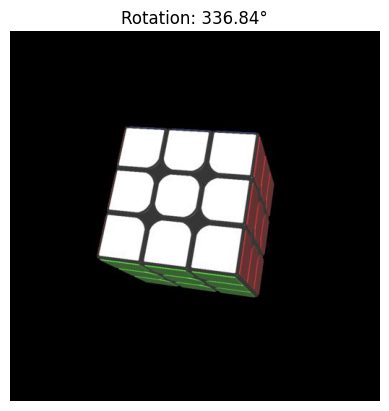

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Correct paths
images_dir = "/content/rubiks_dataset/training/training/images"
labels_path = "/content/rubiks_dataset/training/training/labels.csv"

# Load labels
labels_df = pd.read_csv(labels_path)
print("Labels loaded:")
print(labels_df.head())

# Show first image and label
first_filename = labels_df.iloc[0]["filename"]
first_xrot = labels_df.iloc[0]["xRot"]
first_img_path = os.path.join(images_dir, first_filename)

# Open and display image
img = Image.open(first_img_path)
plt.imshow(img)
plt.title(f"Rotation: {first_xrot:.2f}°")
plt.axis("off")
plt.show()


In [3]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import gc

# Model as per your original architecture
model = Sequential([
    Conv2D(512, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(
    optimizer=Adam(),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error']
)

# Training in chunks
history_list = []
BATCH_SIZE = 100
NUM_CHUNKS = 5000 // BATCH_SIZE

for i in range(NUM_CHUNKS):
    print(f"\nProcessing chunk {i+1}/{NUM_CHUNKS}")

    # Prepare image array
    image_list = []
    label_list = []

    for j in range(i * BATCH_SIZE, (i + 1) * BATCH_SIZE):
        fname = labels_df.iloc[j]["filename"]
        xrot = labels_df.iloc[j]["xRot"]

        img_path = os.path.join(images_dir, fname)
        img = Image.open(img_path).resize((512, 512))
        img_arr = np.array(img) / 255.0  # Keep original size & quality
        image_list.append(img_arr)
        label_list.append(xrot)

    images_array = np.stack(image_list)
    labels_array = np.array(label_list)

    # Train/Test split
    indices = np.arange(len(images_array))
    np.random.shuffle(indices)
    split = int(len(indices) * 0.75)

    train_idx, test_idx = indices[:split], indices[split:]
    train_x, test_x = images_array[train_idx], images_array[test_idx]
    train_y, test_y = labels_array[train_idx], labels_array[test_idx]

    # Train the model
    history = model.fit(
        train_x, train_y,
        validation_data=(test_x, test_y),
        epochs=10,
        batch_size=2,
        verbose=1
    )

    history_list.append(history)
    gc.collect()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Processing chunk 1/50
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 823ms/step - loss: 53873.1250 - mean_absolute_error: 203.4392 - mean_squared_error: 53873.1250 - val_loss: 38685.0117 - val_mean_absolute_error: 171.2930 - val_mean_squared_error: 38685.0117
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 230ms/step - loss: 31623.4004 - mean_absolute_error: 145.7566 - mean_squared_error: 31623.4004 - val_loss: 10203.4609 - val_mean_absolute_error: 79.5027 - val_mean_squared_error: 10203.4609
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 8121.7734 - mean_absolute_error: 72.5966 - mean_squared_error: 8121.7734 - val_loss: 9026.6260 - val_mean_absolute_error: 75.0187 - val_mean_squared_error: 9026.6260
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 6584.6807 - mean_absolute_error: 63.1004 - mean_squared_error: 6584.6807 - val_loss: 12532.6475 - val_mean_absolute_error: 94.9440 - val_mean_squared_error: 12532.6475
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - l

In [7]:
model.save("rubiks_model.h5")
from google.colab import files
files.download("rubiks_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>